<a href="https://colab.research.google.com/github/jbrent00/Senior-Design-Project/blob/ResNet18-L2Reg(.001)-LR(.0001)-DA-DO(.4)-v2/Senior_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Downloading Dataset from Kaggle

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/drive/MyDrive/datasets/chest_xray_pneumonia --unzip


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


# Creating Augmented Images

In [ ]:
!pip install --upgrade Augmentor

In [ ]:
# Create Augmented Images for the "Normal" class in Training Set
import Augmentor
import os

# Step 1: Count Pneumonia Images ---
pneumonia_dir = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/PNEUMONIA"  # Path to pneumonia images in MyDrive
num_pneumonia_images = len(os.listdir(pneumonia_dir))

# Step 2: Create Augmentation Pipeline for Normal Class ---
normal_dir = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/NORMAL"  # Path to normal images in MyDrive
p = Augmentor.Pipeline(normal_dir)  # Path to normal images in MyDrive

# Step 3: Add Augmentations ---
p.rotate(probability=0.3, max_left_rotation=15, max_right_rotation=15)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.5)
p.flip_left_right(probability=0.5)
p.flip_top_bottom(probability=0.5)  # Consider removing or reducing probability for medical images
p.random_distortion(probability=0.9, grid_width=2, grid_height=2, magnitude=8)

# Step 4: Generate Augmented Images and Save to Drive ---
num_augmented_images = num_pneumonia_images - len(os.listdir(normal_dir))  # Number of normal images needed
output_dir = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/augmented_normal"  # Path to save augmented images in MyDrive
p.sample(num_augmented_images)

print(f"Generated {num_augmented_images} augmented images for the normal class and saved to {output_dir}.")

Initialised with 1341 image(s) found.
Output directory set to /content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/NORMAL/output.

Processing <PIL.Image.Image image mode=L size=1824x1426 at 0x7F3BD04CBC50>: 100%|██████████| 2533/2533 [06:38<00:00,  6.35 Samples/s]

Generated 2533 augmented images for the normal class and saved to /content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/augmented_normal.


In [ ]:
import shutil
import os

# Source directory (where augmented images are currently saved)
source_dir = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/output"

# Destination directory (where you want to move the augmented images)
destination_dir = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/NORMAL"

# Move the images
for filename in os.listdir(source_dir):
    source_file = os.path.join(source_dir, filename)  # Full path to the source image
    destination_file = os.path.join(destination_dir, filename)  # Full path to the destination
    shutil.move(source_file, destination_file)  # Move the image

print(f"Augmented images moved from '{source_dir}' to '{destination_dir}'")

Augmented images moved from '/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/output' to '/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train/NORMAL'


In [ ]:
import os

dataset_root = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray/train"
print("Dataset contents:", os.listdir(dataset_root))

Dataset contents: ['NORMAL', 'PNEUMONIA']


# Method to Increase the Validation Set Size

In [ ]:
import os
import shutil
import random

def increase_validation_set(train_dir, val_dir, target_val_size):
    """
    Increases the size of the validation set by moving images from the training set.

    Args:
        train_dir: Path to the training directory.
        val_dir: Path to the validation directory.
        target_val_size: Desired size of the validation set.
    """
    # Calculate how many images to move
    num_to_move = target_val_size - len(os.listdir(os.path.join(val_dir, "NORMAL"))) - len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))

    # Ensure num_to_move is positive
    num_to_move = max(0, num_to_move)

    if num_to_move == 0:
        print("Validation set is already large enough.")
        return

    # Get a list of images in the training set
    train_images_normal = os.listdir(os.path.join(train_dir, "NORMAL"))
    train_images_pneumonia = os.listdir(os.path.join(train_dir, "PNEUMONIA"))

    # Randomly select images to move, ensuring enough images are available
    images_to_move_normal = random.sample(train_images_normal, min(num_to_move // 2, len(train_images_normal)))
    images_to_move_pneumonia = random.sample(train_images_pneumonia, min(num_to_move // 2, len(train_images_pneumonia)))


    # Move the selected images
    for image_name in images_to_move_normal:
        shutil.move(os.path.join(train_dir, "NORMAL", image_name), os.path.join(val_dir, "NORMAL", image_name))
    for image_name in images_to_move_pneumonia:
        shutil.move(os.path.join(train_dir, "PNEUMONIA", image_name), os.path.join(val_dir, "PNEUMONIA", image_name))

    print(f"Moved {len(images_to_move_normal) + len(images_to_move_pneumonia)} images from training set to validation set.")

In [ ]:

# increase_validation_set(train_dir, val_dir, target_val_size=512)

# Verifying Filepaths for Train, Test, Validation Directories before training

In [2]:
# Copy Dataset from Google Drive to Colab
import shutil
import os

# Source (Google Drive Path)
source_path = "/content/drive/MyDrive/datasets/chest_xray_pneumonia/chest_xray"

# Destination (Colab Path)
destination_path = "/content"

# Copy the entire directory tree
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

'/content'

In [3]:
import os

dataset_root = "/content/"

# Paths to Train, Validation, Test Images
train_dir = os.path.join(dataset_root, "train")
val_dir = os.path.join(dataset_root, "val")
test_dir = os.path.join(dataset_root, "test")

# Verify paths
print("Train:", os.listdir(train_dir))
print("Validation:", os.listdir(val_dir))
print("Test:", os.listdir(test_dir))

Train: ['PNEUMONIA', 'NORMAL']
Validation: ['PNEUMONIA', 'NORMAL']
Test: ['PNEUMONIA', 'NORMAL']


In [ ]:
# Delete .DS_Store
!find /content/chest_xray/train /content/chest_xray/val /content/chest_xray/test -name ".DS_Store" -delete

In [4]:
from PIL import Image

# Open the image using PIL
img = Image.open("/content/train/NORMAL/IM-0115-0001.jpeg")

# Check the image mode
if img.mode == "L":
    print("Image is grayscale")
elif img.mode == "RGB":
    print("Image is RGB")
else:
    print("Image is in another format:", img.mode)

Image is grayscale


# Image Preprocessing and Creation of Dataloaders

In [28]:
# Image Preprocessing (Resizing to 224x224, normalize pixel values, data augmentation)
import torchvision.transforms as transforms

# Preprocessing for the TRAINING SET. Not applying augmentation to validation/test set
preprocess_transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    # Augmentations
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    # ---
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

preprocess_transforms_test_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])



In [29]:
# Create PyTorch Dataset and Dataloaders
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Training Set (Normal, Pneumonia, and augmented images)
train_dataset = ImageFolder(root="/content/train", transform=preprocess_transforms_test_val)

# Validation Set (Normal, Pneumonia)
val_dataset = ImageFolder(root="/content/val", transform=preprocess_transforms_test_val)

# Test Set (Normal, Pneumonia)
test_dataset = ImageFolder(root="/content/test", transform=preprocess_transforms_test_val)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
print("Training Set Size: ", len(train_dataset))
print("Validation Set Size: ",len(val_dataset))
print("Test Set Size: ",len(test_dataset))

Training Set Size:  7749
Validation Set Size:  16
Test Set Size:  624


# Displaying some Sample Images from the Dataset

In [ ]:
# Display some sample images to confirm dataset is correctly loaded
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def show_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title("Normal" if label == 0 else "Pneumonia")
        axes[i].axis("off")
    plt.show()

# Display images from the training set
show_images(train_dataset)


In [ ]:
print("Class-to-Index Mapping:", train_dataset.class_to_idx)


Class-to-Index Mapping: {'NORMAL': 0, 'PNEUMONIA': 1}


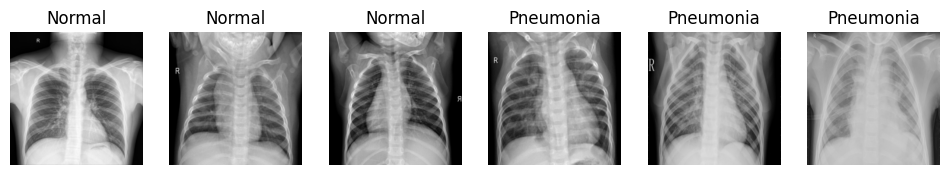

In [ ]:
import random

def show_balanced_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))

    # Collect equal samples of both classes
    normal_images = [img for img, label in dataset if label == 0]
    pneumonia_images = [img for img, label in dataset if label == 1]

    # Ensure we have at least num_images/2 images per class
    num_per_class = num_images // 2
    normal_samples = random.sample(normal_images, min(num_per_class, len(normal_images)))
    pneumonia_samples = random.sample(pneumonia_images, min(num_per_class, len(pneumonia_images)))

    # Combine and shuffle
    samples = normal_samples + pneumonia_samples
    random.shuffle(samples)

    # Display images
    for i, img in enumerate(samples):
        img = img.permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title("Normal" if i < num_per_class else "Pneumonia")
        axes[i].axis("off")

    plt.show()

# Display balanced images
show_balanced_images(train_dataset)


# Initialization of the CNN, Optimizer, and Loss Function

In [31]:
# Initialize the Model: ResNet-18

import torch
import torch.nn as nn
import torchvision.models as models

# Load the ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features  # Get the input size of the FC layer
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),  # Dropout with probability (p= (.5-.2))
    nn.Linear(num_features, 2)  # 2 Classes (Normal, Pneumonia)
)

# Unfreeze the parameters in the new fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)  # Verify model architecture


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:

# Check if layers are frozen
for name, param in model.named_parameters():
    print(f"Layer: {name}, Requires Grad: {param.requires_grad}")

Layer: conv1.weight, Requires Grad: False
Layer: bn1.weight, Requires Grad: False
Layer: bn1.bias, Requires Grad: False
Layer: layer1.0.conv1.weight, Requires Grad: False
Layer: layer1.0.bn1.weight, Requires Grad: False
Layer: layer1.0.bn1.bias, Requires Grad: False
Layer: layer1.0.conv2.weight, Requires Grad: False
Layer: layer1.0.bn2.weight, Requires Grad: False
Layer: layer1.0.bn2.bias, Requires Grad: False
Layer: layer1.1.conv1.weight, Requires Grad: False
Layer: layer1.1.bn1.weight, Requires Grad: False
Layer: layer1.1.bn1.bias, Requires Grad: False
Layer: layer1.1.conv2.weight, Requires Grad: False
Layer: layer1.1.bn2.weight, Requires Grad: False
Layer: layer1.1.bn2.bias, Requires Grad: False
Layer: layer2.0.conv1.weight, Requires Grad: False
Layer: layer2.0.bn1.weight, Requires Grad: False
Layer: layer2.0.bn1.bias, Requires Grad: False
Layer: layer2.0.conv2.weight, Requires Grad: False
Layer: layer2.0.bn2.weight, Requires Grad: False
Layer: layer2.0.bn2.bias, Requires Grad: Fals

In [34]:
# Define Loss Function and Optimizer (using Cross Entropy Loss and Adam Optimizer)

import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=.001)


# Training the Model

In [35]:
# Verify the Model is on the GPU
print(next(model.parameters()).device)

cuda:0


## Use this for early stopping

In [36]:
def train_model_early_stop(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=10):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_loss = float('inf')  # Initialize with a very large value
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * (correct / total)
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * (val_correct / val_total)
        val_avg_loss = val_loss / len(val_loader)
        val_losses.append(val_avg_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_avg_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save model if validation loss is lower than the best seen so far
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            epochs_without_improvement = 0  # Reset counter if improvement
            model_path = "/content/drive/My Drive/chest_xray_models/lowest_loss_models/best_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Model saved to {model_path} with validation loss: {best_val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break  # Exit training loop

    return train_losses, train_accs, val_losses, val_accs

In [37]:
train_losses, train_accs, val_losses, val_accs = train_model_early_stop(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25] - Loss: 0.5407, Acc: 72.38% | Val Loss: 0.5154, Val Acc: 62.50%
Model saved to /content/drive/My Drive/chest_xray_models/lowest_loss_models/best_model.pth with validation loss: 0.5154
Epoch [2/25] - Loss: 0.3572, Acc: 85.68% | Val Loss: 0.4167, Val Acc: 81.25%
Model saved to /content/drive/My Drive/chest_xray_models/lowest_loss_models/best_model.pth with validation loss: 0.4167
Epoch [3/25] - Loss: 0.2868, Acc: 89.44% | Val Loss: 0.3681, Val Acc: 87.50%
Model saved to /content/drive/My Drive/chest_xray_models/lowest_loss_models/best_model.pth with validation loss: 0.3681
Epoch [4/25] - Loss: 0.2619, Acc: 90.04% | Val Loss: 0.3863, Val Acc: 75.00%
Epoch [5/25] - Loss: 0.2467, Acc: 90.70% | Val Loss: 0.3454, Val Acc: 87.50%
Model saved to /content/drive/My Drive/chest_xray_models/lowest_loss_models/best_model.pth with validation loss: 0.3454
Epoch [6/25] - Loss: 0.2266, Acc: 91.65% | Val Loss: 0.3418, Val Acc: 81.25%
Model saved to /content/drive/My Drive/chest_xray_models/l

## Use this for no early stopping

In [ ]:
# Function to Train the Model
# Iterate through the training set in batches, compute the predictions,
# compute the loss, update the models weights, and validate using validation set.

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []


    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get class predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * (correct / total)
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_correct, val_total, val_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * (val_correct / val_total)
        val_avg_loss = val_loss / len(val_loader)
        val_losses.append(val_avg_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_avg_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, train_accs, val_losses, val_accs # Return performance metrics



In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

Epoch [1/25] - Loss: 0.3584, Acc: 84.08% | Val Loss: 0.3201, Val Acc: 87.50%
Epoch [2/25] - Loss: 0.2356, Acc: 90.63% | Val Loss: 0.2958, Val Acc: 81.25%
Epoch [3/25] - Loss: 0.2261, Acc: 91.21% | Val Loss: 0.3172, Val Acc: 81.25%
Epoch [4/25] - Loss: 0.2178, Acc: 91.46% | Val Loss: 0.2089, Val Acc: 93.75%
Epoch [5/25] - Loss: 0.2131, Acc: 91.52% | Val Loss: 0.2349, Val Acc: 87.50%
Epoch [6/25] - Loss: 0.2114, Acc: 91.46% | Val Loss: 0.2763, Val Acc: 81.25%
Epoch [7/25] - Loss: 0.2077, Acc: 91.83% | Val Loss: 0.2238, Val Acc: 87.50%
Epoch [8/25] - Loss: 0.2059, Acc: 91.48% | Val Loss: 0.2021, Val Acc: 93.75%
Epoch [9/25] - Loss: 0.2019, Acc: 92.09% | Val Loss: 0.1773, Val Acc: 100.00%
Epoch [10/25] - Loss: 0.2191, Acc: 91.55% | Val Loss: 0.4531, Val Acc: 75.00%
Epoch [11/25] - Loss: 0.2108, Acc: 91.41% | Val Loss: 0.3996, Val Acc: 75.00%
Epoch [12/25] - Loss: 0.2119, Acc: 91.52% | Val Loss: 0.1709, Val Acc: 100.00%
Epoch [13/25] - Loss: 0.2094, Acc: 91.65% | Val Loss: 0.3111, Val Acc: 

## Statistics

In [38]:
average_val_accuracy = sum(val_accs) / len(val_accs)
print(f"Average Validation Accuracy: {average_val_accuracy:.2f}%")

for i in range(0, len(val_accs), 5):
    # Get the validation accuracies for the current 5-epoch interval
    interval_accs = val_accs[i : i + 5]

    # Calculate the average accuracy for the interval
    avg_acc = sum(interval_accs) / len(interval_accs)

    # Print the average accuracy for the interval
    print(f"Epochs {i + 1}-{i + 5}: Average Validation Accuracy = {avg_acc:.2f}%")

Average Validation Accuracy: 84.00%
Epochs 1-5: Average Validation Accuracy = 78.75%
Epochs 6-10: Average Validation Accuracy = 85.00%
Epochs 11-15: Average Validation Accuracy = 86.25%
Epochs 16-20: Average Validation Accuracy = 83.75%
Epochs 21-25: Average Validation Accuracy = 86.25%


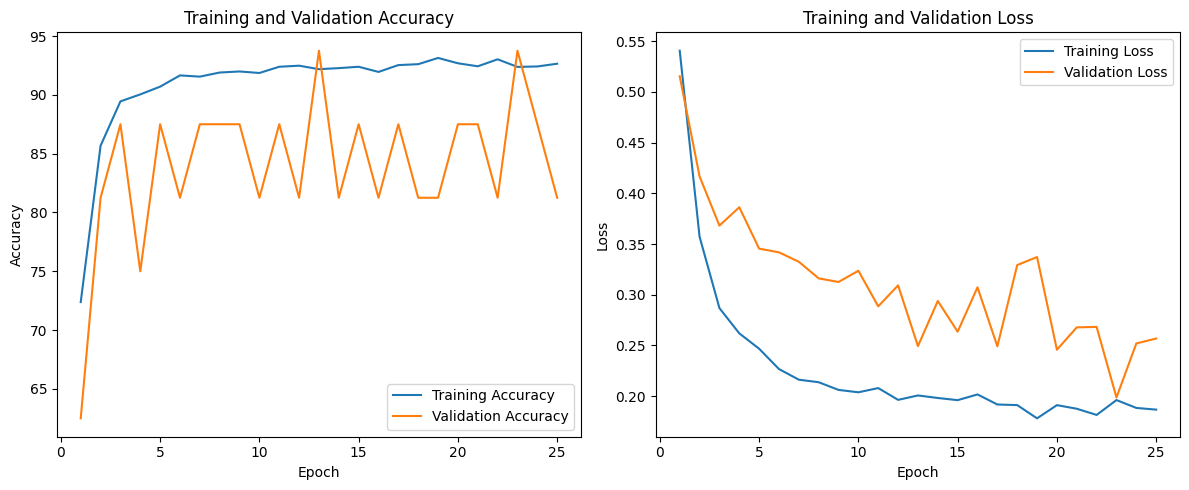

In [39]:
import matplotlib.pyplot as plt

def plot_performance(train_losses, train_accs, val_losses, val_accs):
    """Plots training and validation accuracy/loss vs. epoch."""

    epochs = range(1, len(train_losses) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the plotting function
plot_performance(train_losses, train_accs, val_losses, val_accs)

# K-Fold Cross Validation

In [ ]:
# K-Fold Cross Validation
import torch
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

# Combine train and validation datasets
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

# Define the number of folds (e.g., K=5)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics for each fold
all_train_losses = []
all_train_accs = []
all_val_losses = []
all_val_accs = []


# K-fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(combined_dataset)):
    print(f"Fold {fold + 1}:")

    # Create train and validation subsets using the indices
    train_subset = Subset(combined_dataset, train_index)
    val_subset = Subset(combined_dataset, val_index)

    # Create DataLoaders for this fold
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Create a new model instance
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # create fresh model instance
    num_features = model.fc.in_features  # Get the input size of the FC layer
    model.fc = nn.Linear(num_features, 2)  # Change output to 2 classes (NORMAL, PNEUMONIA)
    model = model.to(device)

    # Create a new optimizer instance
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

    # Train and evaluate for this fold (using the SAME model)
    train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

    # Store the metrics
    all_train_losses.append(train_losses)
    all_train_accs.append(train_accs)
    all_val_losses.append(val_losses)
    all_val_accs.append(val_accs)



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average loss and accuracy across folds for each epoch
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_train_accs = np.mean(all_train_accs, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)
avg_val_accs = np.mean(all_val_accs, axis=0)

# Calculate average loss per fold (across all epochs within each fold)
avg_loss_per_fold = [np.mean(fold_losses) for fold_losses in all_val_losses]

# Plot average loss per fold
plt.figure()
folds = range(1, k + 1)  # Create a range of fold values with step size 1
plt.plot(folds, avg_loss_per_fold, marker='o', linestyle='-')
plt.title("Average Loss per Fold")
plt.xlabel("Fold")
plt.ylabel("Average Loss")
plt.xticks(folds)  # Explicitly set x-axis ticks to fold values
plt.show()

# 2. Average Validation Accuracy per Fold
avg_val_accs_per_fold = [np.mean(accs) for accs in all_val_accs]
plt.figure()
sns.barplot(x=list(range(1, k + 1)), y=avg_val_accs_per_fold)
plt.title("Average Validation Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.show()

# 3. Overall Average Validation Accuracy
overall_avg_val_acc = np.mean(avg_val_accs_per_fold)
print(f"Overall Average Validation Accuracy: {overall_avg_val_acc:.2f}%")

# Evaluate Our Model on the Test Set

In [40]:
# Function to evaluate the model. Make predictions, calculate accuracy

def evaluate_model(model, test_loader):
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class predictions

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_preds  # Return results for further analysis


In [41]:
labels, preds = evaluate_model(model, test_loader)

from sklearn.metrics import classification_report

# Print detailed classification metrics
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))


Test Accuracy: 85.26%
              precision    recall  f1-score   support

      NORMAL       0.94      0.65      0.77       234
   PNEUMONIA       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



In [42]:
# 1. Load the saved model's state dictionary
model_path = "/content/drive/My Drive/chest_xray_models/lowest_loss_models/best_model.pth"  # Path to saved model
model.load_state_dict(torch.load(model_path))

# 2. Run the evaluation and get metrics
labels, preds = evaluate_model(model, test_loader)

# 3. Print the classification report
from sklearn.metrics import classification_report
print(classification_report(labels, preds, target_names=['NORMAL', 'PNEUMONIA']))

Test Accuracy: 88.14%
              precision    recall  f1-score   support

      NORMAL       0.92      0.75      0.83       234
   PNEUMONIA       0.87      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



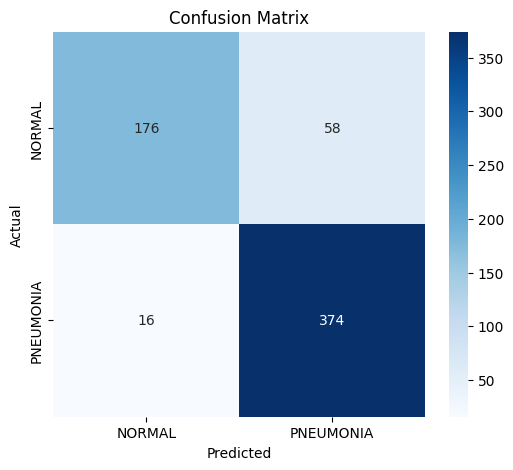

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Save the State Dictionary of the Model for later use

In [44]:
# Save the state dictionary of the model for later use

model_path = "/content/drive/My Drive/chest_xray_models/resnet18_L2Reg001_0001LR_DA_DO04_v3.pth"

# Create the parent directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/chest_xray_models/resnet18_L2Reg001_0001LR_DA_DO04_v3.pth
